In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd /content/drive/MyDrive/SOM

/content/drive/MyDrive/SOM


In [2]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math

In [3]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [4]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM

In [5]:
import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)

In [6]:
import sklearn

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [7]:
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file,
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

In [8]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3),
  include_top=False,
  pooling='avg'
)

17225924/17225924 [==============================] - 1s 0us/step


In [9]:
momaFiles = []

In [13]:
import os
import random
import shutil


source_folder_path = 'class2'
target_folder_path = 'shuffled_images'

image_files = [file for file in os.listdir(source_folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))]


random.shuffle(image_files)

if not os.path.exists(target_folder_path):
    os.makedirs(target_folder_path)

for image_file in image_files:
    source_path = os.path.join(source_folder_path, image_file)
    target_path = os.path.join(target_folder_path, image_file)
    shutil.copyfile(source_path, target_path)

print(f"Saved {len(image_files)} images to {target_folder_path}")


Saved 1355 images to shuffled_images


In [14]:
import os
import shutil

source_folder = 'shuffled_images'
target_folder = 'sorted_images'

os.makedirs(target_folder, exist_ok=True)

file_list = os.listdir(source_folder)
file_list.sort()

for i, file_name in enumerate(file_list):
    file_extension = os.path.splitext(file_name)[1]
    new_name = f"{i}{file_extension}"

    source_path = os.path.join(source_folder, file_name)
    target_path = os.path.join(target_folder, new_name)

    shutil.move(source_path, target_path)

    print(f"Moved: {file_name} -> {new_name} to {target_folder}")
    momaFiles.append(new_name)


Moved: 002f2728aad23d5ca839b57e3b266cb8.jpg -> 0.jpg to sorted_images
Moved: 0066c07cdd6be6c1132c98556616b81a.jpg -> 1.jpg to sorted_images
Moved: 00c19126daf5f1bda3ae48a6a8e6ecc1.jpg -> 2.jpg to sorted_images
Moved: 016e8e953be8b4798c9f22c66e70ece3.jpg -> 3.jpg to sorted_images
Moved: 0268fdd2dd936dcf45e1d3e640dc191d.jpg -> 4.jpg to sorted_images
Moved: 04fb7a76ab54b8a666531a9ce723aec5.jpg -> 5.jpg to sorted_images
Moved: 04fe1aafbf15d01ffc428876b0729276.jpg -> 6.jpg to sorted_images
Moved: 06b46a83b48a963d1fefe03ad77b38c3.jpg -> 7.jpg to sorted_images
Moved: 06ed34bc4ae1baef30110e40163cd540.jpg -> 8.jpg to sorted_images
Moved: 073dbf43f592df8bfda443539cdd4fec.jpg -> 9.jpg to sorted_images
Moved: 07b4ec4ce6a51544dd2c4a4d624a4549.jpg -> 10.jpg to sorted_images
Moved: 08907297f792cfa62be7c68958b671d8.jpg -> 11.jpg to sorted_images
Moved: 08a8a0a90c31aca6fdbde44f2d24b8e1.jpg -> 12.jpg to sorted_images
Moved: 09bfc0570ed530fa4142b3702e877d84.jpg -> 13.jpg to sorted_images
Moved: 0a9b62b73

In [15]:
num_files = len(momaFiles)
print("Number of files in momaFiles:", num_files)

Number of files in momaFiles: 1355


In [16]:
momaFiles = momaFiles[:1000]
momaFiles.sort(key = lambda x:int(x.split('.')[0]))

In [17]:
features = []
folder_path = 'sorted_images'

for filename in momaFiles:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if filename == file:
                path = os.path.join(root, file)
                f = processImage(path, model)
                features.append(f)
                break

1/1 [==============================] - 0s 75ms/step


In [18]:
print(len(features))

1000


In [19]:
featureImagePairs = []
for i in range(len(features)):
    featureImage = {}
    featureImage['image'] = momaFiles[i]
    featureImage['feature'] = features[i]
    featureImagePairs.append(featureImage)

In [20]:
featureImagePairs[0]

{'image': '0.jpg',
 'feature': array([0.02982713, 2.8282006 , 0.        , ..., 0.05683883, 0.        ,
        0.08198944], dtype=float32)}

In [21]:
# Dimensions of the SOM grid
m = 10
n = 10
# Number of training examples
n_x = 1000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = features

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

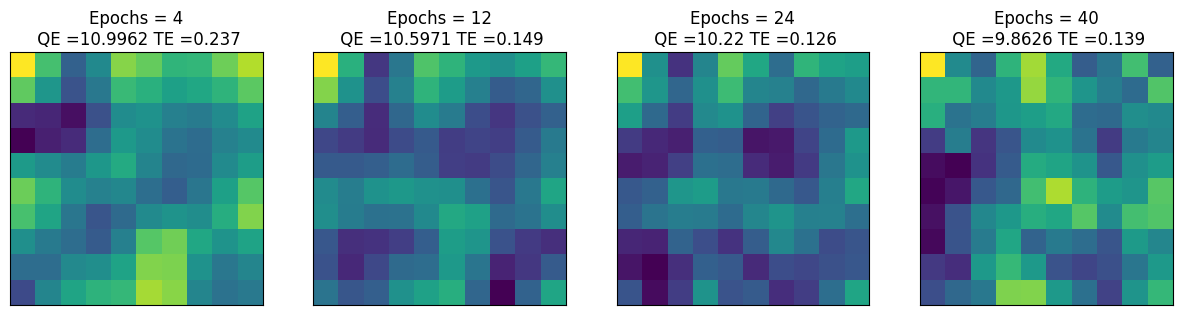

In [23]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([4, 8, 12, 16], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)

    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [24]:
SOMimages = []
for i in range(len(SOM)):
    row = []
    for j in range(len(SOM[0])):
        row.append([])
    SOMimages.append(row)

In [25]:
SOMimages

[[[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []]]

In [26]:
for fi in featureImagePairs:
    g,h = find_BMU(SOM, normalise(train_data, fi['feature']))
    SOMimages[g][h].append(fi)

In [27]:
SOMimages[0][0]

[{'image': '39.jpg',
  'feature': array([0.13576029, 0.        , 0.42599806, ..., 0.7340801 , 0.        ,
         1.2116705 ], dtype=float32)},
 {'image': '51.jpg',
  'feature': array([0.33064458, 0.        , 0.03174054, ..., 1.3259258 , 1.7086868 ,
         1.2201151 ], dtype=float32)},
 {'image': '58.jpg',
  'feature': array([0.5521412 , 0.        , 0.        , ..., 1.4098065 , 0.8691566 ,
         0.56448627], dtype=float32)},
 {'image': '70.jpg',
  'feature': array([2.8018115 , 0.        , 0.7452698 , ..., 0.53391653, 2.278755  ,
         0.02584177], dtype=float32)},
 {'image': '78.jpg',
  'feature': array([0.38546914, 0.        , 0.        , ..., 0.        , 1.0164709 ,
         2.2324808 ], dtype=float32)},
 {'image': '108.jpg',
  'feature': array([0.        , 0.00967729, 0.        , ..., 0.0302373 , 1.0368582 ,
         0.17704672], dtype=float32)},
 {'image': '114.jpg',
  'feature': array([0.54688114, 0.        , 0.06629223, ..., 0.94898164, 1.5193673 ,
         0.3690852 ], 

In [28]:
[[len(c) for c in r] for r in SOMimages]

[[20, 14, 8, 13, 21, 15, 12, 13, 7, 17],
 [14, 8, 10, 9, 5, 8, 6, 8, 11, 10],
 [12, 12, 11, 8, 13, 8, 10, 8, 5, 15],
 [16, 4, 10, 8, 10, 9, 4, 8, 7, 14],
 [9, 8, 6, 7, 6, 13, 7, 12, 5, 10],
 [8, 7, 7, 12, 10, 6, 7, 7, 9, 12],
 [11, 10, 9, 10, 7, 15, 7, 14, 6, 15],
 [10, 6, 17, 8, 7, 6, 10, 8, 5, 9],
 [11, 12, 7, 12, 9, 9, 6, 4, 6, 6],
 [21, 12, 16, 12, 10, 15, 15, 10, 10, 18]]

In [29]:
from scipy import spatial

imageGrid = []
for g in range(len(SOMimages)):
    row = SOMimages[g]
    for h in range(len(row)):
        cell = row[h]
        if len(cell) > 0:
            imageGrid.append(cell[0]['image'])
        else:
            imageGrid.append('white.png')

In [30]:
def img_reshape(img):
    img = Image.open('sorted_images/'+img).convert('RGB')
    img = img.resize((100,100))
    img = np.asarray(img)
    return img

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

img_arr = []
# for image in imageGrid:
#     img_arr.append(img_reshape(image))

for image in imageGrid:
    try:
        img_arr.append(img_reshape(image))
    except FileNotFoundError:
        print(f"File not found: {image}")

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)
    ax.axis('off')
plt.show()

1/1 [==============================] - 0s 59ms/step


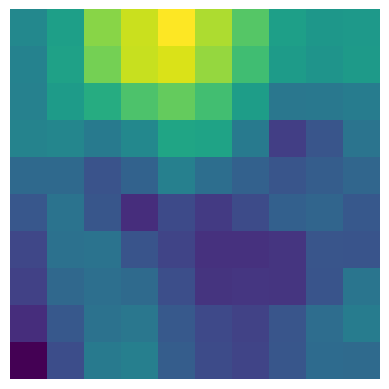

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

selected_image_filename = 'sorted_images/222.jpg'

selected_image = Image.open(selected_image_filename)
selected_image_features = processImage(selected_image_filename, model)
activated_SOM = activate([selected_image_features], SOM, normalise(train_data, [selected_image_features]))

plt.imshow(activated_SOM)
plt.axis('off')
plt.show()


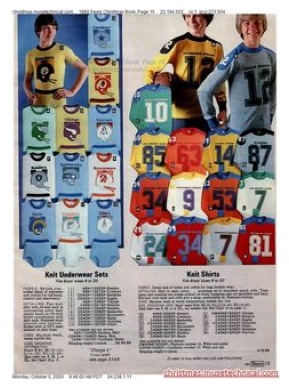

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

selected_image_filename = 'sorted_images/222.jpg'

selected_image = Image.open(selected_image_filename)

plt.imshow(selected_image)
plt.axis('off')
plt.show()
